In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read
# import pysages
import numpy as np
from ase.io import read
from pysages.approxfun import compute_mesh
import pickle
from openmm import unit
from utils import dihedrals
import pysages

pi = np.pi

ERROR:2025-12-05 23:09:18,323:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/xiangrui/miniconda3/envs/sim/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 201, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/xiangrui/miniconda3/envs/sim/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/xiangrui/miniconda3/envs/sim/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/xiangrui/mi

In [30]:
path = 'results/wtmetad_1.2_0.35_200_5000'
# path = '../metadynamics/3D/alanine_dipeptide/test/results_unbiased_long/unbiased'

traj = read(f'{path}.pdb', index=':')
dat = pd.read_csv(f'{path}.dat', header=None, sep='\t')

In [35]:
# dat = dihedrals(traj, [(1,3,4,6),(3,4,6,8)])

## metadynamics

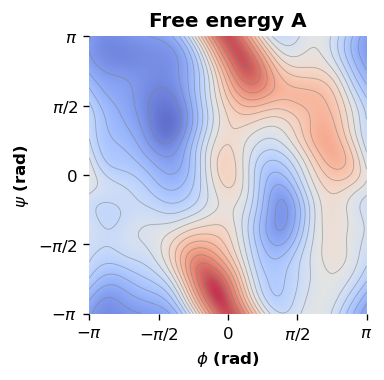

In [ ]:
with open(f'{path}.pkl','rb') as f:
    run_results = pickle.load(f)

fe_result = pysages.analyze(run_results)
metapotential = fe_result["metapotential"]

T = 300 * unit.kelvin
deltaT = 5000
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kB = kB.value_in_unit(unit.kilojoules_per_mole / unit.kelvin)

plot_grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(128, 128), periodic=True)
xi = (compute_mesh(plot_grid) + 1) / 2 * plot_grid.size + plot_grid.lower
alpha = 1 if deltaT is None else (T.value_in_unit(unit.kelvin) + deltaT) / deltaT
kT = kB * T.value_in_unit(unit.kelvin)

A = metapotential(xi) * -alpha / kT
A = A - A.min()
A = A.reshape(plot_grid.shape).T

# Energy landscape
fig, ax = plt.subplots(dpi=120, figsize=(5,3))
im = ax.imshow(A, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi], 
               cmap='coolwarm', alpha=0.8)
contours = ax.contour(A, levels=15, linewidths=0.5, colors="grey", 
                     extent=[-pi, pi, -pi, pi], alpha=0.6)

ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
#ax.set_yticklabels([])
ax.set_xlim(-pi, pi)
ax.set_ylim(-pi, pi)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title(f'Free energy A', fontweight='bold')

# plt.savefig('figures/ala2_FEL.pdf', 
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True,
#             format='pdf')

plt.show()

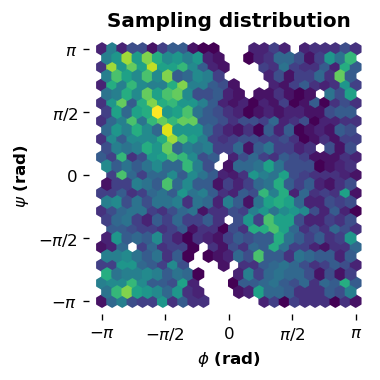

In [70]:
fig, ax = plt.subplots(dpi=120, figsize=(3,3))

ax.hexbin(dat[1][:10000], dat[2][:10000], gridsize=25, mincnt=1)
# ax.hexbin(dat[:,0], dat[:,1], gridsize=25, mincnt=1)
ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title(f'Sampling distribution', fontweight='bold')

plt.savefig('figures/ala2_SD.pdf', 
            dpi=300,
            bbox_inches='tight',
            transparent=True,
            format='pdf')

plt.show()


## ABF

In [16]:
path = 'results/abf_32'

traj = read(f'{path}.pdb', index=':')
dat = pd.read_csv(f'{path}.dat', header=None, sep='\t')

In [17]:
with open(f'{path}.pkl','rb') as f:
    raw_result = pickle.load(f)
result = pysages.analyze(raw_result, topology=(14,))
surface = np.asarray(result["free_energy"])

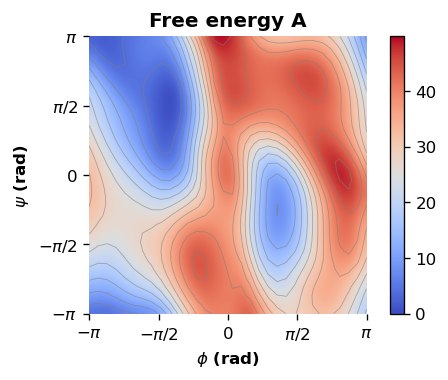

In [20]:
fig, ax = plt.subplots(dpi=120, figsize=(5,3))
im = ax.imshow(
    surface, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi], aspect=1, cmap='coolwarm'
)
contours = ax.contour(surface, levels=15, linewidths=0.5, colors="grey", 
                     extent=[-pi, pi, -pi, pi], alpha=0.6)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')

plt.title(f'Free energy A', fontweight='bold')

# plt.savefig('figures/ala2_ABF_FEL.pdf', 
#             dpi=300,
#             bbox_inches='tight',
#             transparent=True,
#             format='pdf')

plt.colorbar(im)

plt.show()

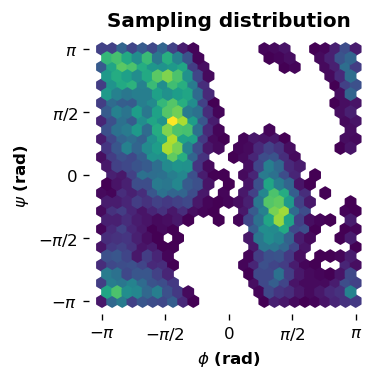

In [73]:
fig, ax = plt.subplots(dpi=120, figsize=(3,3))

ax.hexbin(dat[1][:10000], dat[2][:10000], gridsize=25, mincnt=1)
# ax.hexbin(dat[:,0], dat[:,1], gridsize=25, mincnt=1)
ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title(f'Sampling distribution', fontweight='bold')

plt.savefig('figures/ala2_ABF_SD.pdf', 
            dpi=300,
            bbox_inches='tight',
            transparent=True,
            format='pdf')

plt.show()

## OPES

In [18]:
path = 'results/opes_50_500_0.15'
# path = '../metadynamics/3D/alanine_dipeptide/test/results_unbiased_long/unbiased'

traj = read(f'{path}.pdb', index=':')
dat = pd.read_csv(f'results/opes/fes.dat', header=None, sep=r'\s+', comment='#')
# dat = dihedrals(traj, [(1,3,4,6),(3,4,6,8)])

In [19]:
dat

,0,1,2
0,-3.141593,-3.141593,11.173538
1,-3.043418,-3.141593,10.798685
2,-2.945243,-3.141593,9.613654
3,-2.847068,-3.141593,7.669911
4,-2.748894,-3.141593,6.269316
...,...,...,...
4091,2.650719,3.043418,25.789372
4092,2.748894,3.043418,22.748513
4093,2.847068,3.043418,19.200770
4094,2.945243,3.043418,16.847859


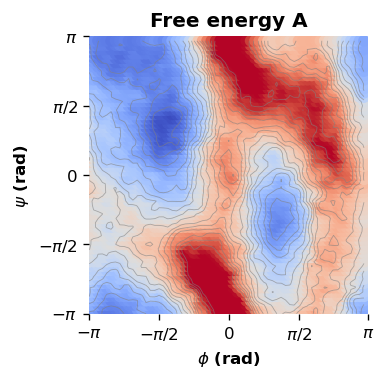

In [ ]:
# Energy landscape
fig, ax = plt.subplots(dpi=120, figsize=(3, 3))

ax.scatter(dat[0], dat[1], c=dat[2], cmap='coolwarm')
contourf = ax.contour(dat[0].to_numpy().reshape((64,64)), dat[1].to_numpy().reshape((64,64)), dat[2].to_numpy().reshape((64,64)), 
                       levels=15, linewidths=0.5, colors="grey", 
                        extent=[-pi, pi, -pi, pi], alpha=0.6)

ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
#ax.set_yticklabels([])
ax.set_xlim(-pi, pi)
ax.set_ylim(-pi, pi)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.title(f'Free energy A', fontweight='bold')

plt.savefig('figures/ala2_OPES_FEL.pdf', 
            dpi=300,
            bbox_inches='tight',
            transparent=True,
            format='pdf')

plt.show()

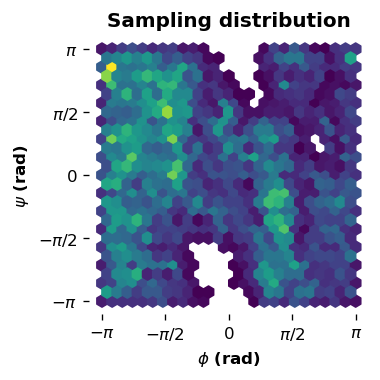

In [52]:
fig, ax = plt.subplots(dpi=120, figsize=(3,3))

ax.hexbin(dat[:,0], dat[:, 1], gridsize=25, mincnt=1)
# ax.hexbin(dat[:,0], dat[:,1], gridsize=25, mincnt=1)
ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title(f'Sampling distribution', fontweight='bold')

plt.savefig('figures/ala2_OPES_SD.pdf', 
            dpi=300,
            bbox_inches='tight',
            transparent=True,
            format='pdf')

plt.show()

In [45]:
dat

,0,1,2,3,4,5,6
0,0.5,-3.082315,-3.132089,0.150000,0.150000,1.969682e-09,-20.045394
1,1.0,2.406236,2.663974,0.150000,0.150000,1.081758e-08,-18.342093
2,1.5,-2.163683,2.321891,0.150000,0.150000,1.969682e-09,-20.045394
3,2.0,-2.950495,1.727507,0.150000,0.150000,1.969682e-09,-20.045394
4,2.5,-1.166358,0.464099,0.150000,0.150000,1.969682e-09,-20.045394
...,...,...,...,...,...,...,...
1995,998.0,0.787538,-1.775665,0.071303,0.071303,1.585623e-02,-5.631597
1996,998.5,1.397761,-2.093007,0.071303,0.071303,7.236319e-03,-6.416048
1997,999.0,1.590894,-2.396224,0.071303,0.071303,6.434569e-04,-8.836061
1998,999.5,0.991130,-1.975301,0.071302,0.071302,1.826455e-02,-5.490202


## Empty frame

/tmp/ipykernel_215760/1880830293.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 600x360 with 6 Axes> than <Figure size 360x360 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(im)


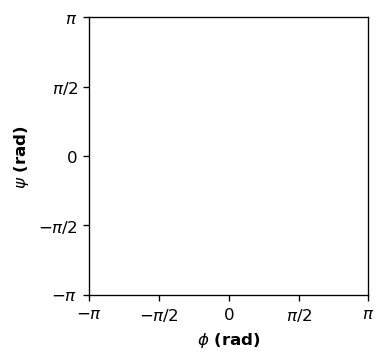

In [24]:
fig, ax = plt.subplots(dpi=120, figsize=(3,3))

# for spine in ax.spines.values():
#     spine.set_visible(False)

ax.set_xlabel(r"$\phi$ (rad)", fontweight='bold')
ax.set_ylabel(r"$\psi$ (rad)", fontweight='bold')
ax.set_xticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')
ax.set_yticks([-pi, -pi/2, 0, pi/2, pi])
ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=10, fontweight='bold')

plt.savefig('figures/ala2_chemical_space.pdf', 
            dpi=300,
            bbox_inches='tight',
            transparent=True,
            format='pdf')

plt.colorbar(im)

plt.show()